In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xgcm import Grid
import gsw
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
warnings.filterwarnings('ignore')
import os
import gc
import geopandas

In [71]:
from dask.distributed import Client
client = Client(n_workers=6,
                threads_per_worker=1,
                memory_limit='24GB')
client

<Client: 'tcp://127.0.0.1:40113' processes=6 threads=6, memory=134.11 GiB>

We first extract one time step of SOSE data, here the first 5-days averaged output of year 2013, along with the two bounding snapshots.

In [72]:
PATH = "/gws/nopw/j04/coast_hack/SOSE_temp/"
year='2013'
#os.listdir(PATH+year)

In [5]:
do_mean=True

In [131]:
it=36

Mass budget terms

In [28]:
ds_VEL_TOT   = xr.open_mfdataset(PATH +f'{year}/*velMass_bsoseI156_{year}_5day.nc')
ds_VEL = ds_VEL_TOT.isel(time=slice(it,it+6))
del(ds_VEL_TOT)
middle_of_month=ds_VEL.time[2]
ds_VEL=ds_VEL.mean('time')
ds_VEL["time"] = middle_of_month
ds_VEL=ds_VEL.set_coords("time")
ds_VEL=ds_VEL.expand_dims("time")

In [29]:
ds_VEL

<xarray.Dataset> Size: 2GB
Dimensions:   (YC: 588, XG: 2160, Z: 52, time: 1, XC: 2160, YG: 588, Zl: 52)
Coordinates: (12/31)
  * YC        (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * XG        (XG) float32 9kB 5.551e-17 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * Z         (Z) float32 208B -2.1 -6.7 -12.15 ... -5e+03 -5.4e+03 -5.8e+03
    dyG       (YC, XG) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    dxC       (YC, XG) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    rAw       (YC, XG) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    ...        ...
    Depth     (YC, XC) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    maskInC   (YC, XC) bool 1MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    rSurfC    (YC, XC) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    rLowC     (YC, XC) float32 5MB dask.array<chunksize=(588, 2160), meta=np.ndarray>
    iter      int64 8B dask.array<chunksize=(), meta=np.ndarray>
  * time      (time) datetime64[ns] 8B 2013-07-14
Data variables:
    UVELMASS  (time, Z, YC, XG) float32 264MB dask.array<chunksize=(1, 52, 588, 2160), meta=np.ndarray>
    VVELMASS  (time, Z, YG, XC) float32 264MB dask.array<chunksize=(1, 52, 588, 2160), meta=np.ndarray>
    WVELMASS  (time, Zl, YC, XC) float32 264MB dask.array<chunksize=(1, 52, 588, 2160), meta=np.ndarray>

In [33]:
ds_SSH_TOT   = xr.open_mfdataset(PATH +f'{year}/SSH_bsoseI156_{year}_5day.nc')
ds_SSH = ds_SSH_TOT.isel(time=slice(it,it+6))
ds_SSH = ds_SSH.rename({"ETAN":"SSH"})
del(ds_SSH_TOT)
ds_SSH=ds_SSH.mean('time')
ds_SSH["time"] = middle_of_month
ds_SSH=ds_SSH.set_coords("time")
ds_SSH=ds_SSH.expand_dims("time")

In [34]:
ds_SSH_SNAPS_TOT   = xr.open_mfdataset(PATH +f'{year}/SSH_bsoseI156_{year}_5daySnaps.nc')
ds_SSH_SNAPS = ds_SSH_SNAPS_TOT.isel(time=slice(it,it+7,6))
ds_SSH_SNAPS = ds_SSH_SNAPS.rename({"time":"time_bounds","ETAN":"SSH_bounds"})
del(ds_SSH_SNAPS_TOT)

In [35]:
ds_FWFLUX_TOT = xr.open_dataset(PATH + f'{year}/oceFWflx_bsoseI156_{year}_5day.nc')
ds_FWFLUX = ds_FWFLUX_TOT.isel(time=slice(it,it+6))
del(ds_FWFLUX_TOT)
ds_FWFLUX=ds_FWFLUX.mean('time')
ds_FWFLUX["time"] = middle_of_month
ds_FWFLUX=ds_FWFLUX.set_coords("time")
ds_FWFLUX=ds_FWFLUX.expand_dims("time")

Heat budget terms

In [36]:
ds_THETA_TOT = xr.open_dataset(PATH + f'{year}/Theta_bsoseI156_{year}_5day.nc')
ds_THETA = ds_THETA_TOT.isel(time=slice(it,it+6))
del(ds_THETA_TOT)
ds_THETA=ds_THETA.mean('time')
ds_THETA["time"] = middle_of_month
ds_THETA=ds_THETA.set_coords("time")
ds_THETA=ds_THETA.expand_dims("time")

In [37]:
ds_THETA_SNAPS_TOT = xr.open_dataset(PATH + f'{year}/Theta_bsoseI156_{year}_5daySnaps.nc')
ds_THETA_SNAPS = ds_THETA_SNAPS_TOT.isel(time=slice(it,it+7,6))
del(ds_THETA_SNAPS_TOT)
ds_THETA_SNAPS = ds_THETA_SNAPS.rename({"THETA":"THETA_bounds","time":"time_bounds"})

In [38]:
#ds_TTEND_TOT = xr.open_dataset(PATH +f'{year}/TOTTTEND_bsoseI156_{year}_5day.nc')
#ds_TTEND = ds_TTEND_TOT.isel(time=slice(0,1))
#del(ds_TTEND_TOT)

In [39]:
ds_ADV_TH_TOT   = xr.open_mfdataset([PATH +f'{year}/ADVx_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVy_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVr_TH_bsoseI156_{year}_5day.nc'])
ds_ADV_TH = ds_ADV_TH_TOT.isel(time=slice(it,it+6))
del(ds_ADV_TH_TOT)
ds_ADV_TH=ds_ADV_TH.mean('time')
ds_ADV_TH["time"] = middle_of_month
ds_ADV_TH=ds_ADV_TH.set_coords("time")
ds_ADV_TH=ds_ADV_TH.expand_dims("time")

In [40]:
ds_DIFF_TH_TOT  = xr.open_mfdataset([PATH +f'{year}/DFxE_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFyE_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFrI_TH_bsoseI156_{year}_5day.nc'])
ds_DIFF_TH = ds_DIFF_TH_TOT.isel(time=slice(it,it+6))
del(ds_DIFF_TH_TOT)
ds_DIFF_TH=ds_DIFF_TH.mean('time')
ds_DIFF_TH["time"] = middle_of_month
ds_DIFF_TH=ds_DIFF_TH.set_coords("time")
ds_DIFF_TH=ds_DIFF_TH.expand_dims("time")

In [41]:
ds_TFLUX_TOT = xr.open_dataset(PATH + f'{year}/surfTflx_bsoseI156_{year}_5day.nc')
ds_TFLUX = ds_TFLUX_TOT.isel(time=slice(it,it+6))
del(ds_TFLUX_TOT)
ds_TFLUX=ds_TFLUX.mean('time')
ds_TFLUX["time"] = middle_of_month
ds_TFLUX=ds_TFLUX.set_coords("time")
ds_TFLUX=ds_TFLUX.expand_dims("time")

In [42]:
ds_SW_TOT    = xr.open_dataset(PATH + f'{year}/oceQsw_bsoseI156_{year}_5day.nc')
ds_SW = ds_SW_TOT.isel(time=slice(it,it+6))
del(ds_SW_TOT)
ds_SW=ds_SW.mean('time')
ds_SW["time"] = middle_of_month
ds_SW=ds_SW.set_coords("time")
ds_SW=ds_SW.expand_dims("time")

Salt budget terms

In [43]:
ds_SALT_TOT = xr.open_dataset(PATH + f'{year}/Salt_bsoseI156_{year}_5day.nc')
ds_SALT = ds_SALT_TOT.isel(time=slice(it,it+6))
del(ds_SALT_TOT)
ds_SALT=ds_SALT.mean('time')
ds_SALT["time"] = middle_of_month
ds_SALT=ds_SALT.set_coords("time")
ds_SALT=ds_SALT.expand_dims("time")

In [44]:
ds_SALT_SNAPS_TOT = xr.open_dataset(PATH + f'{year}/Salt_bsoseI156_{year}_5daySnaps.nc')
ds_SALT_SNAPS = ds_SALT_SNAPS_TOT.isel(time=slice(it,it+7,6))
del(ds_SALT_SNAPS_TOT)
ds_SALT_SNAPS = ds_SALT_SNAPS.rename({"SALT":"SALT_bounds","time":"time_bounds"})

In [138]:
ds_SALT_SNAPS_TOT = xr.open_dataset(PATH + f'{year}/Salt_bsoseI156_{year}_5daySnaps.nc')

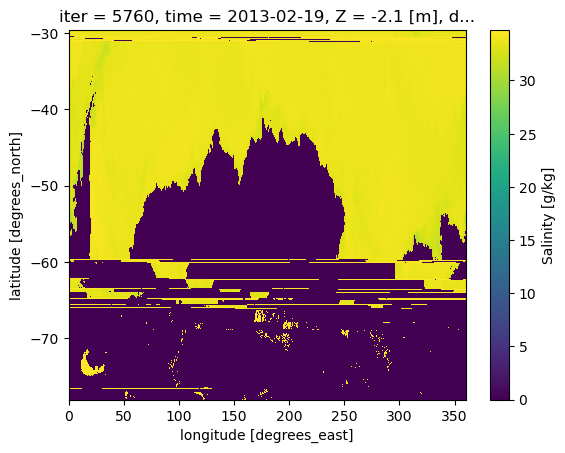

In [147]:
ds_SALT_SNAPS_TOT["SALT"].isel(time=10,Z=0).plot()

In [132]:
ds_SALT_SNAPS = ds_SALT_SNAPS_TOT.isel(time=slice(it,it+7,6))
ds_SALT_SNAPS

<xarray.Dataset> Size: 880MB
Dimensions:  (time: 2, XC: 2160, YC: 588, Z: 52)
Coordinates: (12/14)
    iter     (time) int64 16B ...
  * time     (time) datetime64[ns] 16B 2013-06-29 2013-07-29
  * XC       (XC) float32 9kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC       (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 208B -2.1 -6.7 -12.15 ... -5e+03 -5.4e+03 -5.8e+03
    rA       (YC, XC) float32 5MB ...
    ...       ...
    hFacC    (Z, YC, XC) float32 264MB ...
    maskC    (Z, YC, XC) bool 66MB ...
    maskInC  (YC, XC) bool 1MB ...
    rhoRef   (Z) float32 208B ...
    rSurfC   (YC, XC) float32 5MB ...
    rLowC    (YC, XC) float32 5MB ...
Data variables:
    SALT     (time, Z, YC, XC) float32 528MB ...

In [45]:
#ds_STEND_TOT = xr.open_dataset(PATH +f'{year}/TOTSTEND_bsoseI156_{year}_5day.nc')
#ds_STEND = ds_STEND_TOT.isel(time=slice(0,1))
#del(ds_STEND_TOT)

In [46]:
ds_ADV_SLT_TOT   = xr.open_mfdataset([PATH +f'{year}/ADVx_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVy_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVr_SLT_bsoseI156_{year}_5day.nc'])
ds_ADV_SLT = ds_ADV_SLT_TOT.isel(time=slice(it,it+6))
del(ds_ADV_SLT_TOT)
ds_ADV_SLT=ds_ADV_SLT.mean('time')
ds_ADV_SLT["time"] = middle_of_month
ds_ADV_SLT=ds_ADV_SLT.set_coords("time")
ds_ADV_SLT=ds_ADV_SLT.expand_dims("time")

In [47]:
ds_DIFF_SLT_TOT  = xr.open_mfdataset([PATH +f'{year}/DFxE_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFyE_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFrI_SLT_bsoseI156_{year}_5day.nc'])
ds_DIFF_SLT = ds_DIFF_SLT_TOT.isel(time=slice(it,it+6))
del(ds_DIFF_SLT_TOT)
ds_DIFF_SLT=ds_DIFF_SLT.mean('time')
ds_DIFF_SLT["time"] = middle_of_month
ds_DIFF_SLT=ds_DIFF_SLT.set_coords("time")
ds_DIFF_SLT=ds_DIFF_SLT.expand_dims("time")

In [48]:
ds_SFLUX_TOT = xr.open_dataset(PATH + f'{year}/surfSflx_bsoseI156_{year}_5day.nc')
ds_SFLUX = ds_SFLUX_TOT.isel(time=slice(it,it+6))
del(ds_SFLUX_TOT)
ds_SFLUX=ds_SFLUX.mean('time')
ds_SFLUX["time"] = middle_of_month
ds_SFLUX=ds_SFLUX.set_coords("time")
ds_SFLUX=ds_SFLUX.expand_dims("time")

In [49]:
ds_MEAN_DATA=xr.merge([ds_VEL, ds_FWFLUX,
                       ds_THETA, ds_ADV_TH , ds_DIFF_TH,  ds_TFLUX, ds_SW,
                       ds_SALT , ds_ADV_SLT, ds_DIFF_SLT,ds_SFLUX],compat="override")

In [50]:
ds_SNAPS_DATA=xr.merge([ds_SSH_SNAPS,ds_THETA_SNAPS,ds_SALT_SNAPS],compat="override")

In [24]:
# Put the averaged data between two snapshot time steps on the time axis
#ds_MEAN_DATA["time"] = ds_MEAN_DATA["time"] - np.timedelta64(2, 'D') - np.timedelta64(12, 'h')

In [51]:
ds_MEAN_DATA=ds_MEAN_DATA.drop_vars("iter")
ds_SNAPS_DATA=ds_SNAPS_DATA.drop_vars("iter")

In [52]:
ds=xr.merge([ds_MEAN_DATA,ds_SNAPS_DATA])

In [53]:
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at center
ds['depthC'] = ds['drC'].sum('Z') #vertical cell size at center

ds['CV']= ds.rA * ds.drC # Cell volume 
ds['rAW'] = ds.dyG * ds.drW # cell side areas at u location
ds = ds.set_coords( ("drW","drS","drC","CV","rAW") )

In [127]:
ds

<xarray.Dataset> Size: 14GB
Dimensions:           (YC: 588, XG: 2160, Z: 52, time: 1, XC: 2160, YG: 588,
                       Zl: 52, time_bounds: 2)
Coordinates: (12/38)
  * YC                (YC) float32 2kB -77.98 -77.95 -77.91 ... -29.87 -29.72
  * XG                (XG) float32 9kB 5.551e-17 0.1667 0.3333 ... 359.7 359.8
  * Z                 (Z) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (YC, XG) float32 5MB ...
    dxC               (YC, XG) float32 5MB ...
    rAw               (YC, XG) float32 5MB ...
    ...                ...
  * time_bounds       (time_bounds) datetime64[ns] 16B 2013-06-29 2013-07-29
    drW               (Z, YC, XG) float32 264MB ...
    drS               (Z, YG, XC) float32 264MB ...
    drC               (Z, YC, XC) float32 264MB ...
    CV                (YC, XC, Z) float32 264MB ...
    rAW               (YC, XG, Z) float32 264MB ...
Data variables: (12/40)
    UVELMASS          (time, Z, YC, XG) float32 264MB ...
    VVELMASS          (time, Z, YG, XC) float32 264MB ...
    WVELMASS          (time, Zl, YC, XC) float32 264MB ...
    oceFWflx          (time, YC, XC) float32 5MB ...
    THETA             (time, Z, YC, XC) float32 264MB ...
    ADVy_TH           (time, Z, YG, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    ...                ...
    DELTA_ADVx_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_ADVy_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_ADVr_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFxE_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFyE_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFrI_SLT    (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0

In [73]:
#ds.to_netcdf("./SOSE_2013-07-14_T000000_30days.nc")
ds = xr.open_dataset("./SOSE_2013-07-14_T000000_30days.nc")

The dataset `ds` contains all diagnostics required to close the mass, heat and salt budgets

In [74]:
# Create xgcm.Grid instance

metrics = {
        ('X',): ['dxC', 'dxG'], # X distances
        ('Y',): ['dyC', 'dyG'], # Y distances
        ('Z',): ['drF','drW', 'drS', 'drC'], # Z distances
        ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
    }

coords={'X': {'center': 'XC', 'left': 'XG'},
        'Y': {'center': 'YC', 'left': 'YG'},
        'Z': {'center': 'Z', 'left': 'Zl'},
        'T': {'center': 'time', 'outer': 'time_bounds'}}

grid = Grid(ds,  periodic=['X'], coords=coords, metrics = metrics, boundary={'X':'periodic','Y':'extend','Z':'fill','T':'extend'}, fill_value=0)
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary='fill'):
  * center   Z --> left
  * left     Zl --> center
T Axis (not periodic, boundary='extend'):
  * center   time --> outer
  * outer    time_bounds --> center

In [75]:
rho_0 = 1035.     # kg/m3
Cp = 3994.        # J/kg/K
g_to_kg = 0.001  
day_per_second = 1/86400.

In [76]:
mask2D = (1.-ds.maskInC).isel(YC=slice(0,587))
land = (mask2D == 1).isel(YC=slice(0,587))
maskZ = xr.DataArray(np.zeros(len(ds['Z'])),dims=['Z'],coords={'Z':ds['Z']})
maskZ[0] = 1 

### Mass budget ###

The computation is Boussinesq, and z* stretching takes into account the evolution of the free surface:
$$ 
\int_{-H}^{\eta} \nabla \cdot \vec{u} \mathrm{d} z = \frac{\partial \eta}{\partial t}
$$
Integrating over the horizontal area of the water column, and discretizing in the vertical direction $k$, we obtain:
$$ 
\sum_k \left(\iiint \nabla \cdot \vec{u}\mathrm{d} V \right)_{ijk} = \iint_{S_{xy}} \frac{\partial \eta}{\partial t} \mathrm{d} S = A_{xy} \frac{\partial \eta}{\partial t},
$$
where $A_{xy}$ is the area of the water column.
Thus, the divergence integrated over the volume of a single cell can be computed as:
$$
\left(\iiint \nabla \cdot \vec{u}\mathrm{d} V \right)_{ijk} = \left( A_{xy} \frac{\partial \eta}{\partial t}  \right) \times \frac{dz_k}{H}
$$
The divergence integrated over the volume of a single cell is also given, applying Stokes theorem, by:
$$
\left(\iiint \nabla \cdot \vec{u}\mathrm{d} V \right)_{ijk} = (dSx_{i+1}U_{i+1} - dSx_i U_i) + (dSy_{j+1}V_{j+1} - dSy_j V_j) + (dSz_{k+1}W_{k+1} - dSz_k W_k ) 
$$
i, j, k are the zonal, meridional and vertical indices, respectively. \
U, V, W are the zonal, meridional and vertical velocity fields, respectively. \
dSx, dSy, dSz are the associated cell areas.

Combining these last two equations and multiplying them by $\rho_0$, we obtain our cell-by-cell mass budget:
$$
\rho_0 \left( \left( A_{xy} \frac{\partial \eta}{\partial t}\right) \times \frac{dz_k}{H} \right) = \rho_0 \left( (dSx_{i+1}U_{i+1} - dSx_i U_i) + (dSy_{j+1}V_{j+1} - dSy_j V_j) + (dSz_{k+1}W_{k+1} - dSz_k W_k ) \right) 
$$

In [77]:
# Compute the mass transports
grid._ds["UMASSTRANS"] = ds["UVELMASS"] * ds.dyG * ds.drF * rho_0
grid._ds["VMASSTRANS"] = ds["VVELMASS"] * ds.dxG * ds.drF * rho_0
grid._ds["WMASSTRANS"] = ds["WVELMASS"] * ds.rA * rho_0

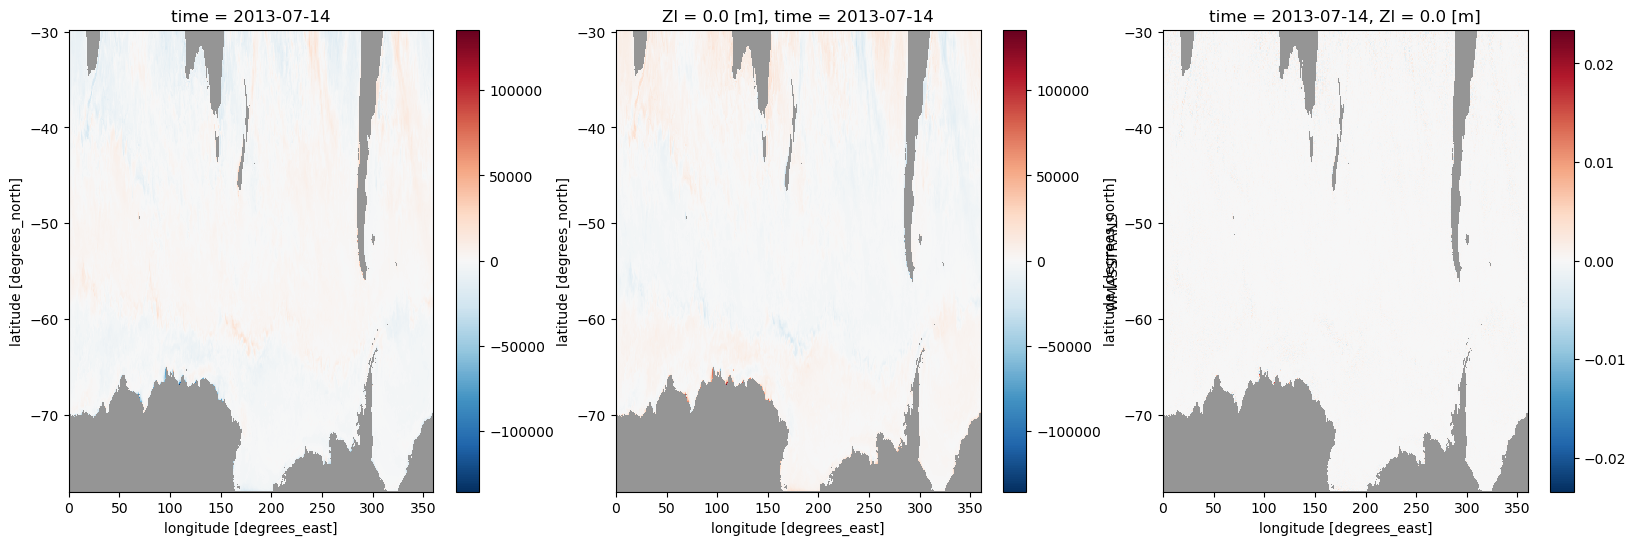

In [78]:
# Show that the vertical mass transport at the surface is equal to (minus) the net fresh water flux at the surface
# the difference is about 7 orders of magnitude less than the terms, which is expected with single precision output
fig,axs=plt.subplots(1,3,figsize=(20,6))

land.plot(ax=axs[0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds["oceFWflx"].isel(time=0)*ds.rA).where(mask2D == 0).plot(ax=axs[0])
land.plot(ax=axs[1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds['WMASSTRANS'].isel(time=0,Zl=0)).where(mask2D == 0).plot(ax=axs[1])
land.plot(ax=axs[2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds["oceFWflx"].isel(time=0)*ds.rA + ds['WMASSTRANS'].isel(time=0,Zl=0)).where(mask2D == 0).plot(ax=axs[2]);

In [79]:
# Compute zonal divergence of zonal transport
ds["DELTA_UMASSTRANS"]=grid.diff(ds['UMASSTRANS'],'X') 
ds["DELTA_UMASSTRANS"].compute();

In [80]:
# Compute meridional divergence of meridional transport
ds["DELTA_VMASSTRANS"]=grid.diff(ds['VMASSTRANS'],'Y',boundary = 'extend') 
ds["DELTA_VMASSTRANS"].compute();

In [81]:
ds["WMASSTRANS"][dict(time=0, Zl=0)] = 0.0

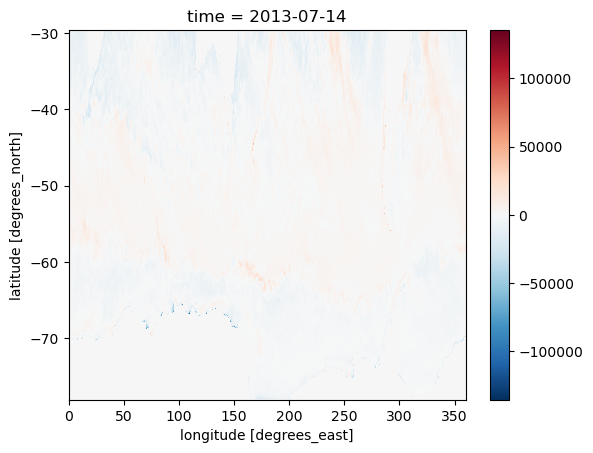

In [82]:
(ds["oceFWflx"].isel(time=0)*ds.rA).plot()

In [83]:
# Compute vertical divergence of vertical transport
ds["DELTA_WMASSTRANS"]=grid.diff(ds['WMASSTRANS'],'Z',boundary = 'fill', fill_value = 0)
ds["DELTA_WMASSTRANS"].compute();

In [84]:
# Sum to obtain divergence
DIV = - ds["DELTA_UMASSTRANS"] - ds["DELTA_VMASSTRANS"] + ds["DELTA_WMASSTRANS"]

In [85]:
delta_t=(((ds.time_bounds[1]-ds.time_bounds[0]))/np.timedelta64(1, 's')).values

In [86]:
delta_t

array(2592000.)

In [87]:
WEIGHTS = grid._ds["drC"]/grid._ds["depthC"]
SSH_TEND = grid.diff(ds['SSH_bounds'],'T')/delta_t
ds["SSH_TEND_3D"] = SSH_TEND*WEIGHTS
ds["SSH_TEND_3D"].compute();

In [88]:
ds

<xarray.Dataset> Size: 10GB
Dimensions:           (YC: 588, XG: 2160, Z: 52, time: 1, XC: 2160, YG: 588,
                       Zl: 52, time_bounds: 2)
Coordinates: (12/38)
  * YC                (YC) float32 2kB -77.98 -77.95 -77.91 ... -29.87 -29.72
  * XG                (XG) float32 9kB 5.551e-17 0.1667 0.3333 ... 359.7 359.8
  * Z                 (Z) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (YC, XG) float32 5MB ...
    dxC               (YC, XG) float32 5MB ...
    rAw               (YC, XG) float32 5MB ...
    ...                ...
  * time_bounds       (time_bounds) datetime64[ns] 16B 2013-06-29 2013-07-29
    drW               (Z, YC, XG) float32 264MB ...
    drS               (Z, YG, XC) float32 264MB ...
    drC               (Z, YC, XC) float32 264MB ...
    CV                (YC, XC, Z) float32 264MB ...
    rAW               (YC, XG, Z) float32 264MB ...
Data variables: (12/32)
    UVELMASS          (time, Z, YC, XG) float32 264MB ...
    VVELMASS          (time, Z, YG, XC) float32 264MB ...
    WVELMASS          (time, Zl, YC, XC) float32 264MB ...
    oceFWflx          (time, YC, XC) float32 5MB ...
    THETA             (time, Z, YC, XC) float32 264MB ...
    ADVx_TH           (time, Z, YC, XG) float32 264MB ...
    ...                ...
    VMASSTRANS        (time, Z, YG, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    WMASSTRANS        (time, Zl, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_UMASSTRANS  (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_VMASSTRANS  (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_WMASSTRANS  (time, Z, YC, XC) float32 264MB 0.0 0.0 0.0 ... 0.0 0.0
    SSH_TEND_3D       (time, YC, XC, Z) float64 528MB nan nan nan ... -0.0 -0.0

In [89]:
# Vertically sum these terms
DIV_2D = DIV.sum('Z')
DELTA_UMASSTRANS_2D = ds.DELTA_UMASSTRANS.sum('Z')
DELTA_VMASSTRANS_2D = ds.DELTA_VMASSTRANS.sum('Z')
DELTA_WMASSTRANS_2D = ds.DELTA_WMASSTRANS.sum('Z')

In [90]:
ZSTARSTRETCH_MASS = rho_0 * ds.rA * ds.SSH_TEND_3D

In [91]:
LHS = ZSTARSTRETCH_MASS

In [92]:
RHS = DIV + ds["oceFWflx"]*ds.rA*maskZ

In [93]:
RES = LHS - RHS

In [94]:
RES2D = RES.sum('Z')

In [95]:
DIV_2D = DIV_2D.rename("DIV")
RES2D = RES2D.rename("RES")

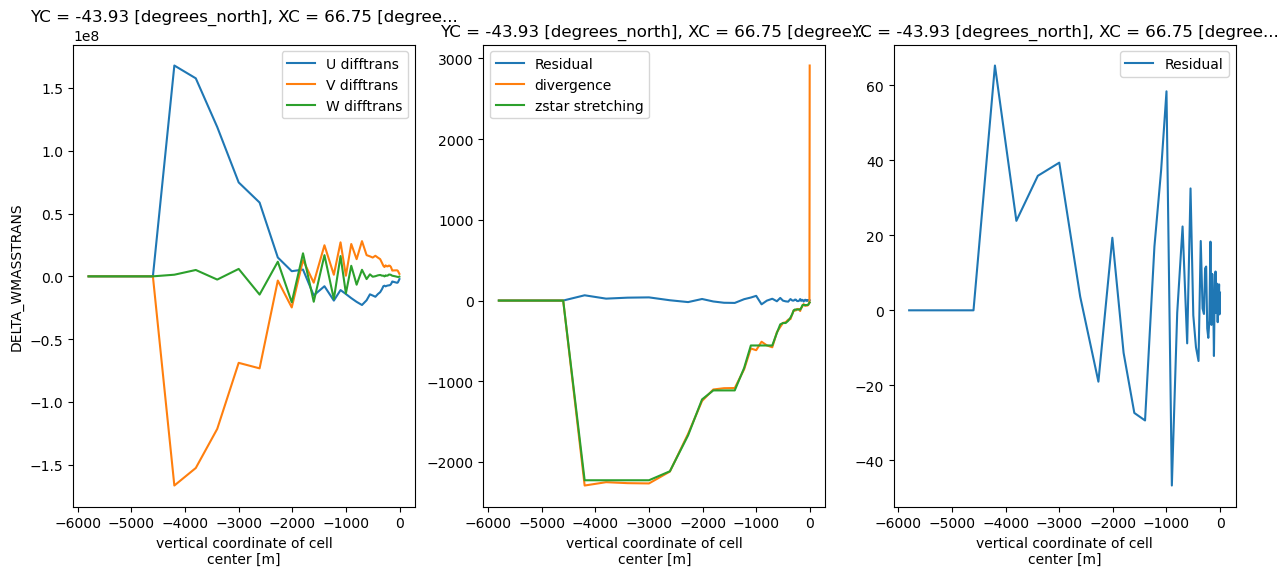

In [96]:
# Example vertical profile of the mass budget
ix=400
iy=480
fig,axs=plt.subplots(1,3,figsize=(15,6))

ds.DELTA_UMASSTRANS.isel(time=0,XC=ix,YC=iy).plot(ax=axs[0],label='U difftrans')
ds.DELTA_VMASSTRANS.isel(time=0,XC=ix,YC=iy).plot(ax=axs[0],label='V difftrans')
ds.DELTA_WMASSTRANS.isel(time=0,XC=ix,YC=iy).plot(ax=axs[0],label='W difftrans') 
RES.isel(time=0,XC=ix,YC=iy).plot(ax=axs[1],label='Residual')
DIV.isel(time=0,XC=ix,YC=iy).plot(ax=axs[1],label='divergence')
ZSTARSTRETCH_MASS.isel(time=0,XC=ix,YC=iy).plot(ax=axs[1],label='zstar stretching')
RES.isel(time=0,XC=ix,YC=iy).plot(ax=axs[2],label='Residual')
axs[0].legend();
axs[1].legend();
axs[2].legend();

The budget is closed down to machine precision, since we have about 7 orders of magnitude of difference between the dominating terms and the residual. 

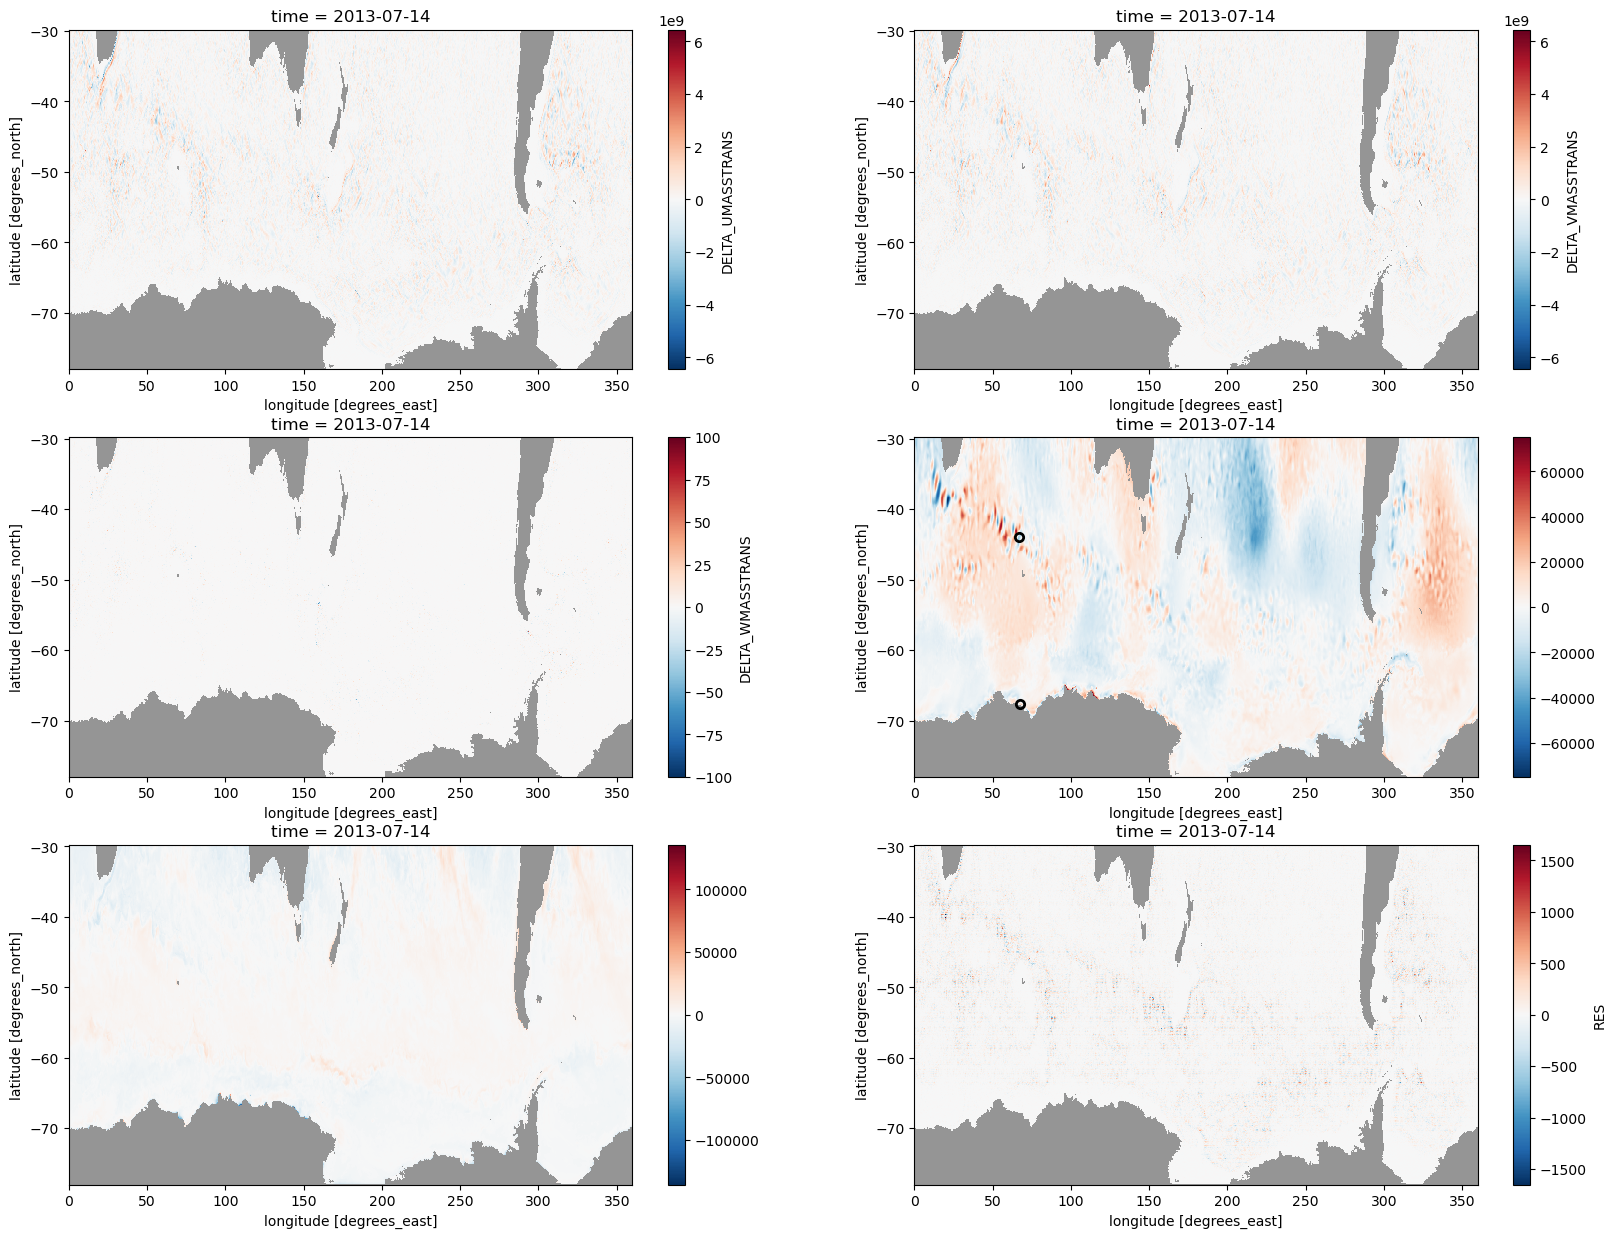

In [97]:
# plot vertically integrated terms

fig,axs=plt.subplots(3,2,figsize=(20,15))

land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DELTA_UMASSTRANS_2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])

land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DELTA_VMASSTRANS_2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])

land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DELTA_WMASSTRANS_2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])

land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ZSTARSTRETCH_MASS.sum('Z')).isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,1])

land.plot(ax=axs[2,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds["oceFWflx"]*ds.rA).isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[2,0])

land.plot(ax=axs[2,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[2,1])

# location of the vertical profiles on the DIV plot
axs[1,1].plot(67.42,-67.61,'o',markeredgewidth=2,markeredgecolor='black',markerfacecolor='None' )
axs[1,1].plot(66.75,-43.93,'o',markeredgewidth=2,markeredgecolor='black',markerfacecolor='None' );

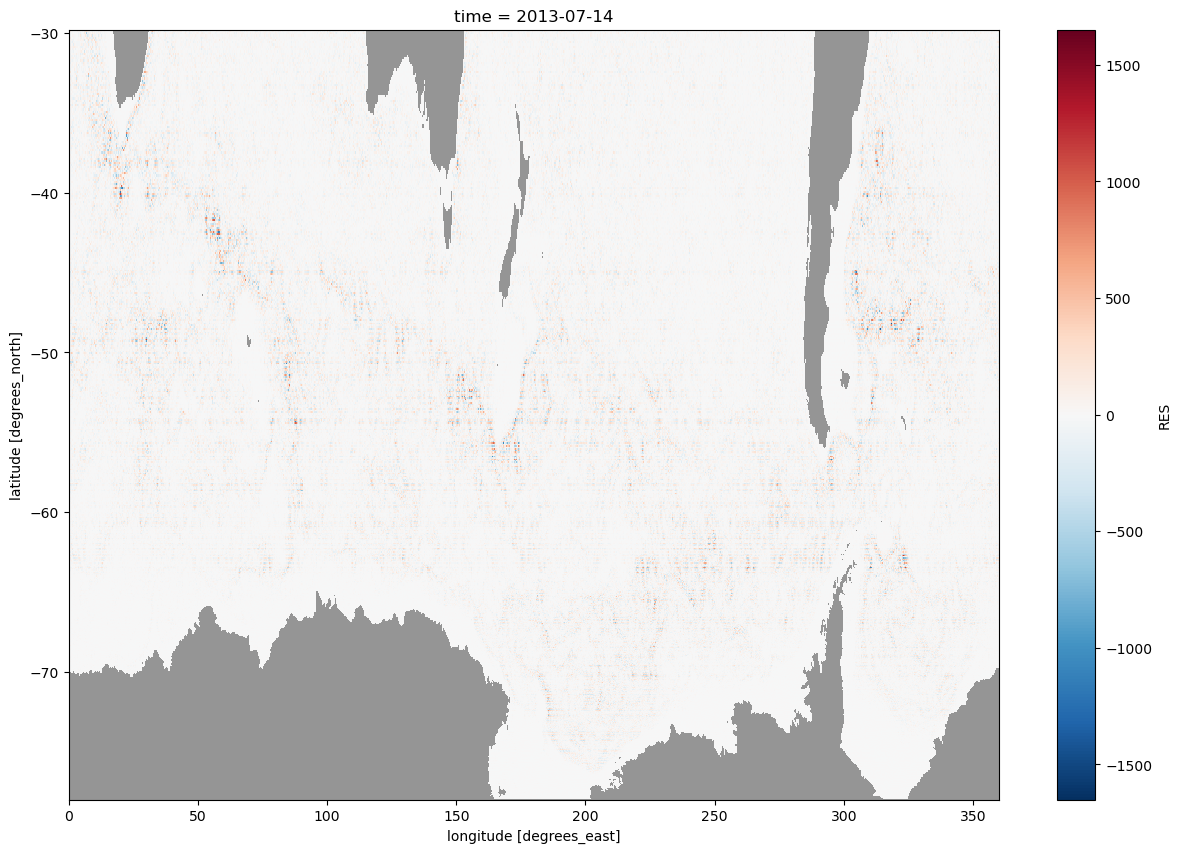

In [98]:
fig,axs=plt.subplots(1,1,figsize=(15,10))
land.plot(ax=axs, cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs)

Higher values of the residual are found in regions of high activity, but still remain low enough

In [99]:
ds=ds.drop_vars(["WMASSTRANS","DELTA_UMASSTRANS","DELTA_VMASSTRANS"])

In [100]:
del(LHS,RHS,DELTA_UMASSTRANS_2D,DELTA_VMASSTRANS_2D,DELTA_WMASSTRANS_2D,
    DIV, DIV_2D,RES,RES2D,WEIGHTS,ZSTARSTRETCH_MASS)

### Heat budget ###

The heat budget should be:
$$
\frac{d ( \text{Heat content})}{d t} = \text{ADVECTION} + \text{DIFFUSION} + \text{SHORT WAVE HEATING} + \text{SURFACE NON SW HEATING}
$$

But we saw that the divergence is non-zero, so we have to add the divergence contribution, which is:
$$
\text{DIV}_{\text{Heat}} = C_p \text{DIV}_{\text{Mass}} \theta
$$
With $\theta$ the potential temperature, $C_p = 3992 J/kg/C$ the specific heat capacity of sea water 

Note that some of the outputted diagnostics indicate temperature tendencies (tracer concentration tendencies). We want to close the budget for tracer content (total cell heat content), thus we multiply ADV and DIFF by $\rho_0 \times C_p$ and the Eulerian temperature tendency by $\text{VOLUME} \times \rho_0 \times C_p$

We compute these terms in the following.

In [101]:
ds["sTHETA"] = ds.THETA_bounds*(1+ds.SSH_bounds/ds.depthC)
ds["TEMP_TEND"] = grid.diff(ds['sTHETA'],'T') / delta_t
HEAT_TEND =  ds.TEMP_TEND * ds.rA * ds.drC * rho_0 * Cp
HEAT_TEND = HEAT_TEND.rename('HEAT_TEND')

In [102]:
ds["DELTA_ADVx_TH"] = grid.diff(ds['ADVx_TH'],'X')
ds["DELTA_ADVy_TH"] = grid.diff(ds['ADVy_TH'],'Y',boundary = 'extend')
ds["DELTA_ADVr_TH"] = grid.diff(ds['ADVr_TH'],'Z',boundary = 'fill', fill_value = 0)

In [103]:
ADV_HEAT = (ds["DELTA_ADVx_TH"] + ds["DELTA_ADVy_TH"] - ds["DELTA_ADVr_TH"]) * rho_0 * Cp
ADV_HEAT = ADV_HEAT.rename('ADV_HEAT')

In [104]:
ds["DELTA_DFxE_TH"] = grid.diff(ds['DFxE_TH'],'X')  
ds["DELTA_DFyE_TH"] = grid.diff(ds['DFyE_TH'],'Y',boundary = 'extend') 
ds["DELTA_DFrI_TH"] = grid.diff(ds['DFrI_TH'],'Z',boundary = 'fill', fill_value = 0)

In [105]:
DF_HEAT = (-ds["DELTA_DFxE_TH"] - ds["DELTA_DFyE_TH"] + ds["DELTA_DFrI_TH"]) * rho_0 * Cp
DF_HEAT = DF_HEAT.rename('DF_HEAT')

In [106]:
# The short wave heating term demands a bit of work

Zlp1 = np.concatenate([ds.Zl.values,[-6000.]])
q1 = 0.62 * np.exp(Zlp1[:-1]/0.6) + (1-0.62) * np.exp(Zlp1[:-1]/20.0) 
q2 = 0.62 * np.exp(Zlp1[1:]/0.6) + (1-0.62) * np.exp(Zlp1[1:]/20.0)

# Correction for the 200m cutoff
zCut = np.where(ds.Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[ds.Z],dims=['Z'])
q2 = xr.DataArray(q2,coords=[ds.Z],dims=['Z'])
landmask = ds.hFacC.copy(deep=True).compute()
landmask.values[landmask.values > 0] = 1
ds["TFLUXmSW"] = (ds['TFLUX'] - (1-q1[0]+q2[0])*ds['oceQsw']) * landmask.isel(Z=0)
SF = ds["TFLUXmSW"] * ds.rA
## Calculate subsurface shortwave radiation penetration 
SBSFQSW = ((q1 * (landmask == 1)-q2*(landmask.shift(Z=-1)==1))*ds['oceQsw']).rename('QSW')
SBSFQSW.values[SBSFQSW.Z == -2.1] = 0 
ds["SBSFQSW"] = SBSFQSW
SBSFQSW = ds["SBSFQSW"] * ds.rA

In [107]:
LHS = HEAT_TEND + ADV_HEAT

In [108]:
RHS = DF_HEAT + SF*maskZ + SBSFQSW

In [109]:
# Here compute the heat budget first with, then without the divergence term

RES = LHS - RHS

In [110]:
RES2D = RES.sum('Z')
HEAT_TEND2D = HEAT_TEND.sum('Z')
ADV_HEAT2D = ADV_HEAT.sum('Z')
SBSFQSW2D = SBSFQSW.sum('Z')
DF_HEAT2D = DF_HEAT.sum('Z')

In [111]:
SBSFQSW2D = SBSFQSW2D.rename("Short wave")
SF = SF.rename("non-SW heat flux")
RES2D = RES2D.rename("Residual")

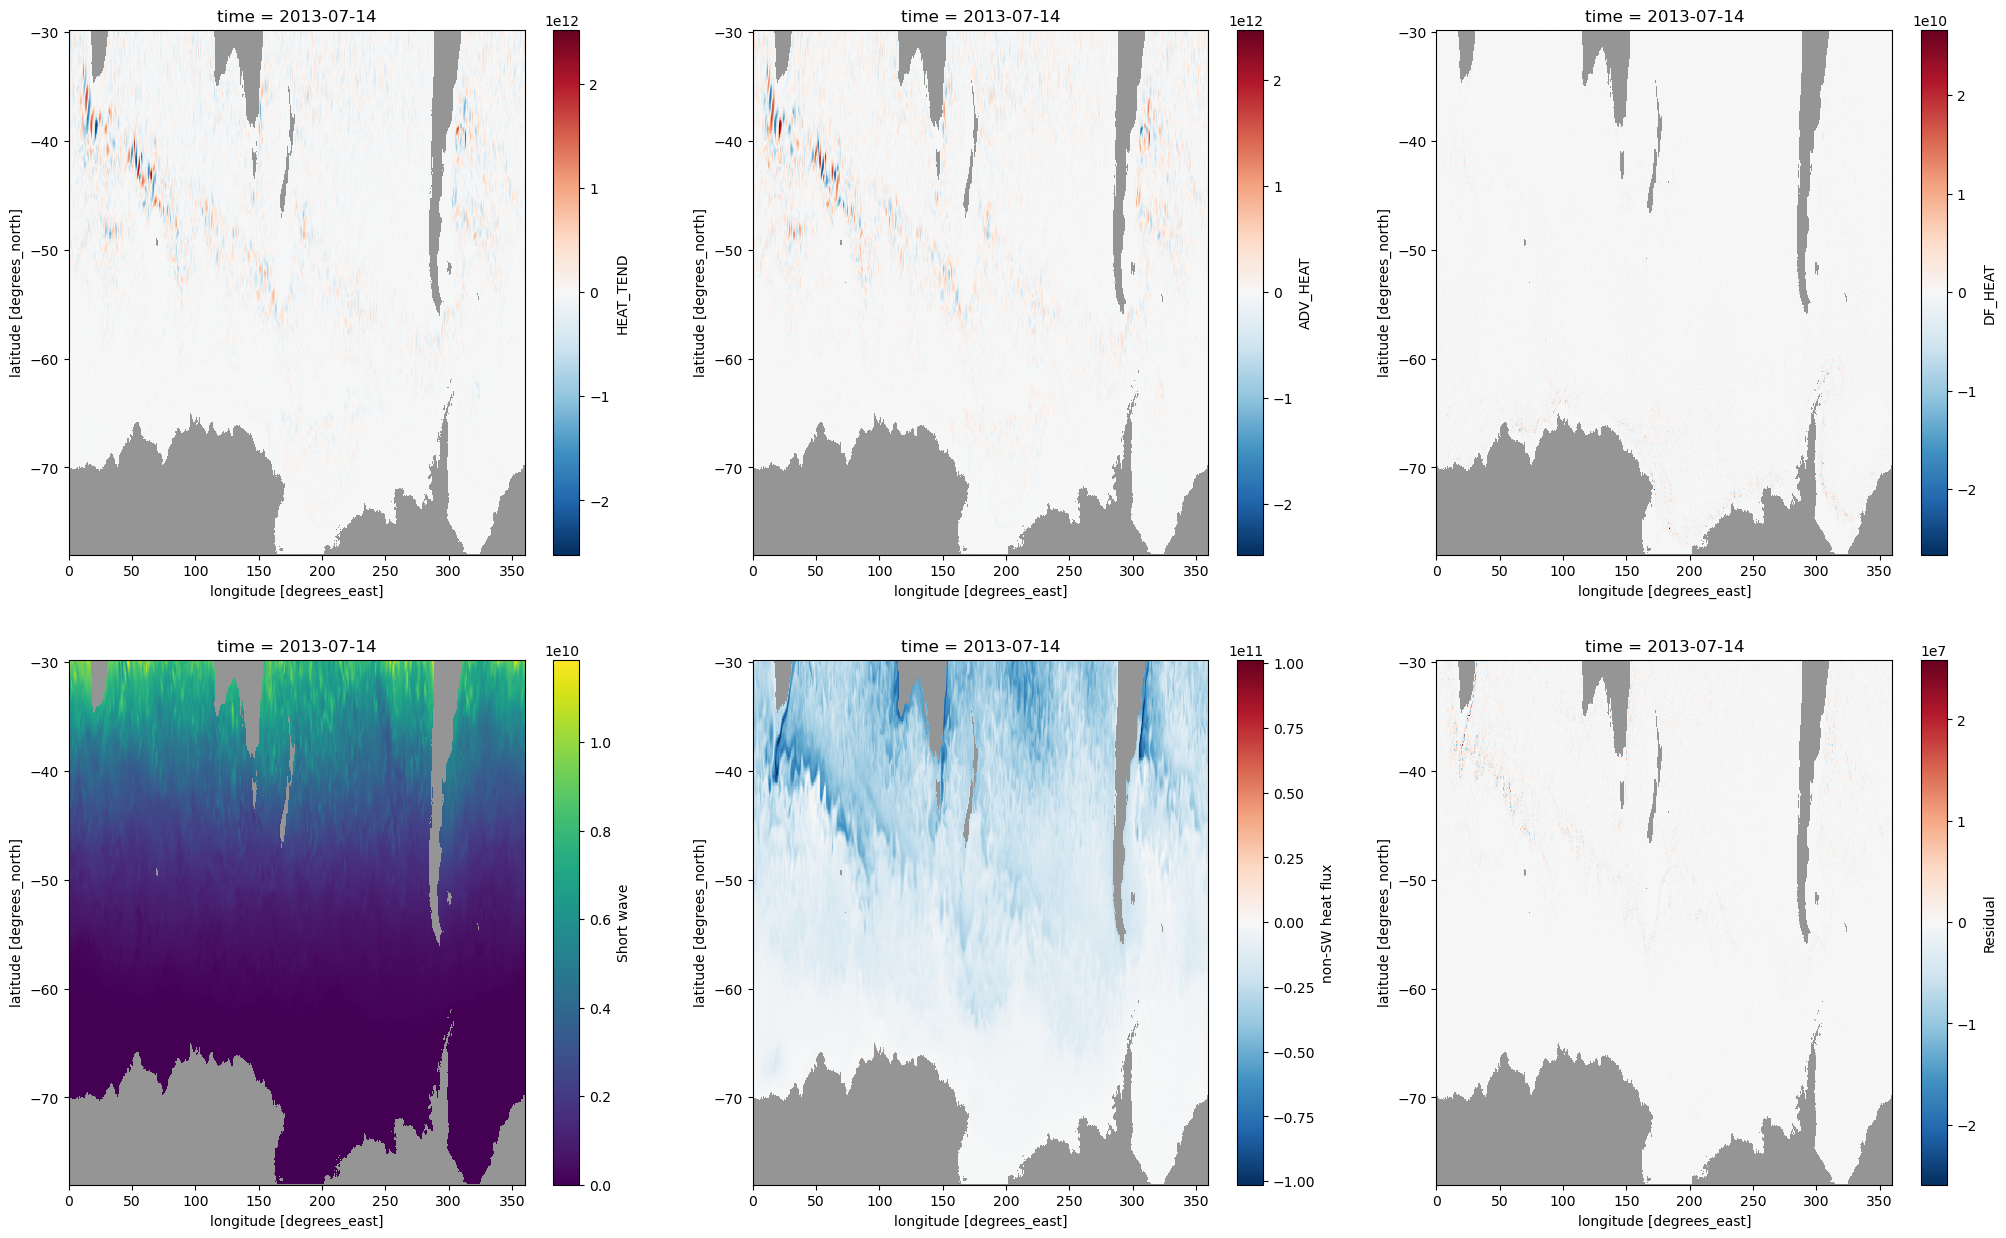

In [112]:
fig,axs=plt.subplots(2,3,figsize=(25,15))

land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
HEAT_TEND2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])
land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ADV_HEAT2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])
land.plot(ax=axs[0,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DF_HEAT2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,2])
land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SBSFQSW2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])
land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SF.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,1])
land.plot(ax=axs[1,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(time=0,YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,2]);


In [113]:
ds=ds.drop_vars(["ADVx_TH","ADVx_TH","ADVr_TH",
                 "DFxE_TH","DFyE_TH","DFrI_TH",
                 "TFLUX","oceQsw"])

In [114]:
del(ADV_HEAT,ADV_HEAT2D,
    DF_HEAT,DF_HEAT2D,
    HEAT_TEND,HEAT_TEND2D,
    LHS,RHS,RES,RES2D,
    SBSFQSW,SBSFQSW2D,SF,SSH_TEND )

### Salt budget ###

Taking into account the "salt divergence term", the salt budget should be:
$$
\frac{d ( \text{Salt content})}{d t} = \text{ADVECTION} + \text{DIFFUSION} + \text{SURFACE SALT FLUX} + \text{DIV}_{\text{Salt}}
$$
with
$$
\text{DIV}_{\text{Salt}} = 0.001 \times \text{DIV}_{\text{Mass}} \times S
$$
With $S$ the salinity, the 0.001 multiplication converting from grams of salt to kilograms of salt.  

Again, we want the budgets to be made in tracer content (salt) and not in tracer concentration (salinity).

We compute these terms in the following.

In [115]:
ds["sSALIN"] = ds.SALT_bounds*(1+ds.SSH_bounds/ds.depthC)
ds["SALIN_TEND"] = grid.diff(ds['sSALIN'],'T') / delta_t
SALT_TEND =  ds.SALIN_TEND * rho_0 * ds.rA * ds.drC * g_to_kg
SALT_TEND = SALT_TEND.rename('SALT_TEND')

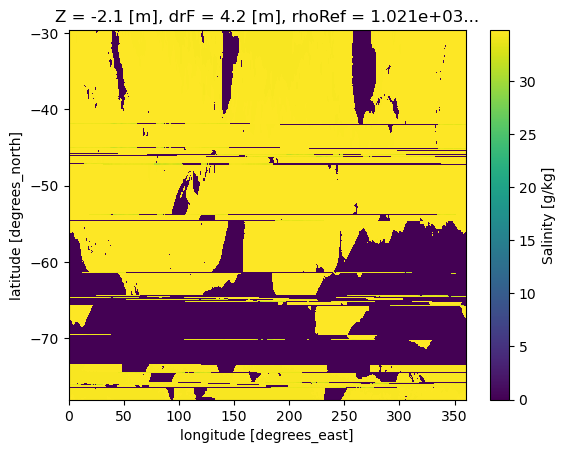

In [137]:
ds["SALT_bounds"].isel(time_bounds=1,Z=0).plot()

In [116]:
ds["DELTA_ADVx_SLT"] = grid.diff(ds['ADVx_SLT'],'X')
ds["DELTA_ADVy_SLT"] = grid.diff(ds['ADVy_SLT'],'Y',boundary = 'extend')
ds["DELTA_ADVr_SLT"] = grid.diff(ds['ADVr_SLT'],'Z',boundary = 'fill', fill_value = 0)

In [117]:
ADV_SALT = (ds["DELTA_ADVx_SLT"] + ds["DELTA_ADVy_SLT"] - ds["DELTA_ADVr_SLT"]) * rho_0 * g_to_kg
ADV_SALT = ADV_SALT.rename('ADV_SALT')

In [118]:
ds["DELTA_DFxE_SLT"] = grid.diff(ds['DFxE_SLT'],'X')  
ds["DELTA_DFyE_SLT"] = grid.diff(ds['DFyE_SLT'],'Y',boundary = 'extend') 
ds["DELTA_DFrI_SLT"] = grid.diff(ds['DFrI_SLT'],'Z',boundary = 'fill', fill_value = 0)

In [119]:
DF_SALT = (- ds["DELTA_DFxE_SLT"] - ds["DELTA_DFyE_SLT"] + ds["DELTA_DFrI_SLT"]) * rho_0 * g_to_kg
DF_SALT = DF_SALT.rename('DF_SALT')

In [120]:
SALTFLX = ds["SFLUX"] * ds.rA * g_to_kg * maskZ

In [121]:
LHS = SALT_TEND + ADV_SALT

In [122]:
RHS = DF_SALT + SALTFLX

In [123]:
RES =  LHS - RHS

In [124]:
RES2D = RES.sum('Z')
SALT_TEND2D = SALT_TEND.sum('Z')
ADV_SLT2D = ADV_SALT.sum('Z')
SALTFLX2D = SALTFLX.sum('Z')
DIFF_SLT2D = DF_SALT.sum('Z')


In [125]:
SALTFLX2D = SALTFLX2D.rename("Salt surf flux")
RES2D = RES2D.rename("Residual")

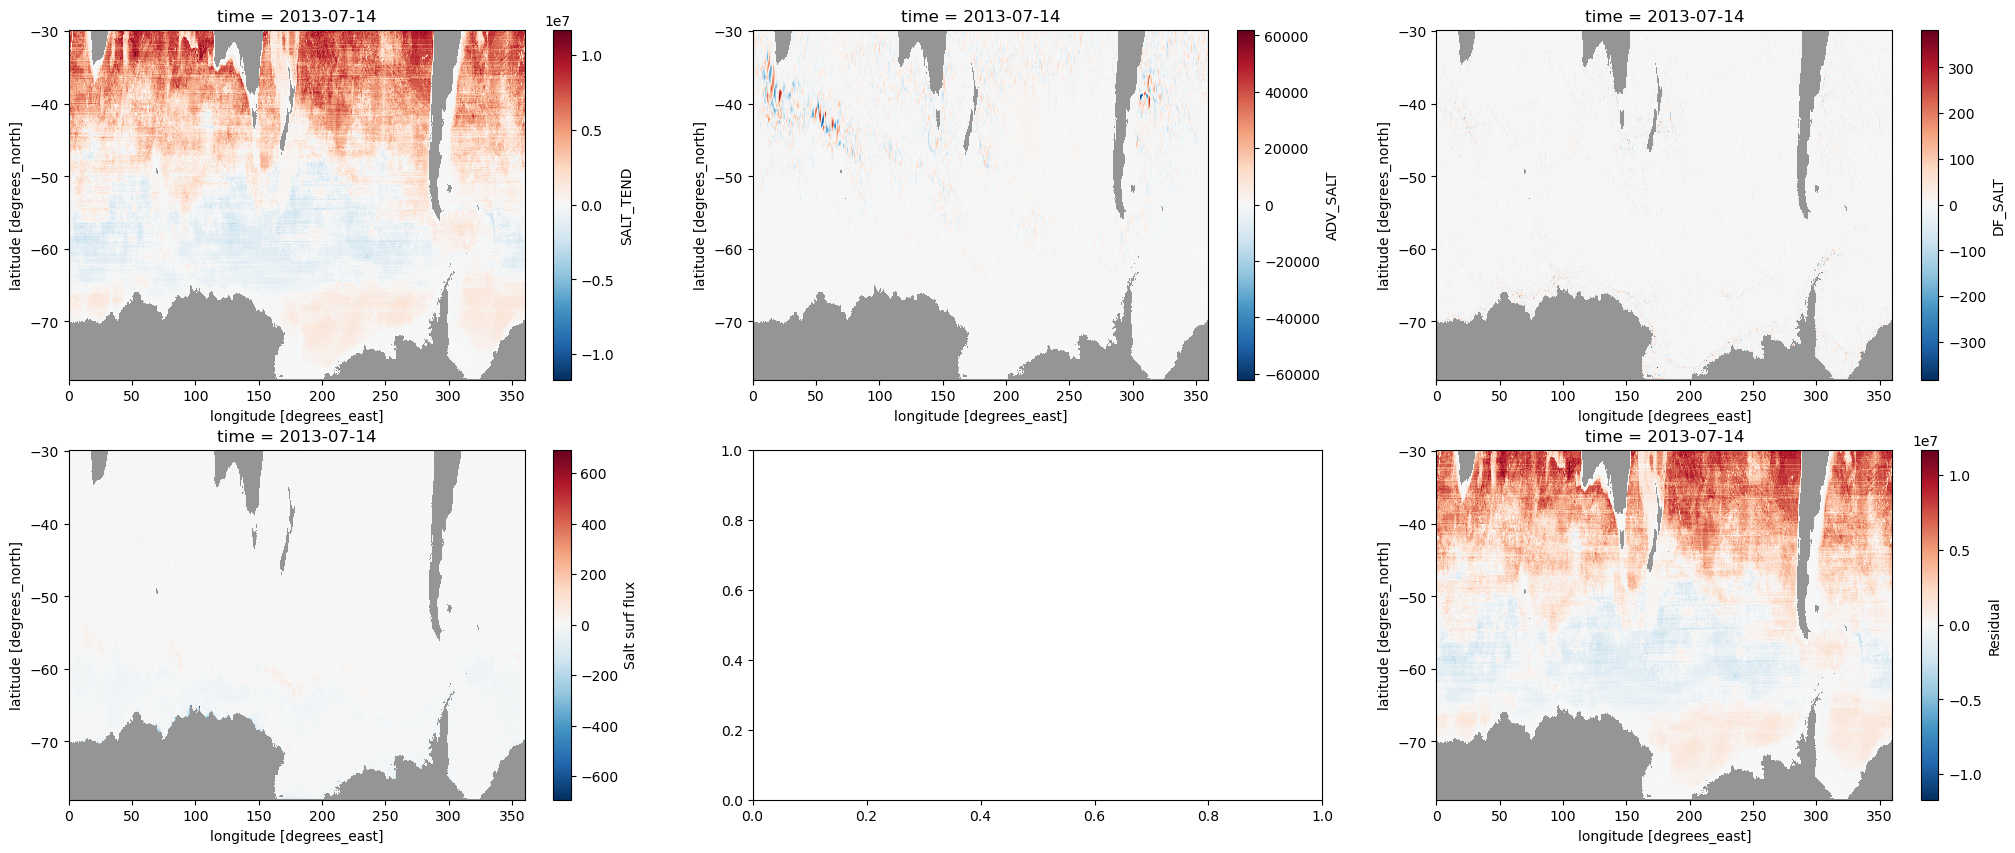

In [126]:
fig,axs=plt.subplots(2,3,figsize=(25,10))
land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SALT_TEND2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])
land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ADV_SLT2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])
land.plot(ax=axs[0,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFF_SLT2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,2])
land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SALTFLX2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])
land.plot(ax=axs[1,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,2]);


Again, including the tracer divergence term is necessasy to improve budget closure. 

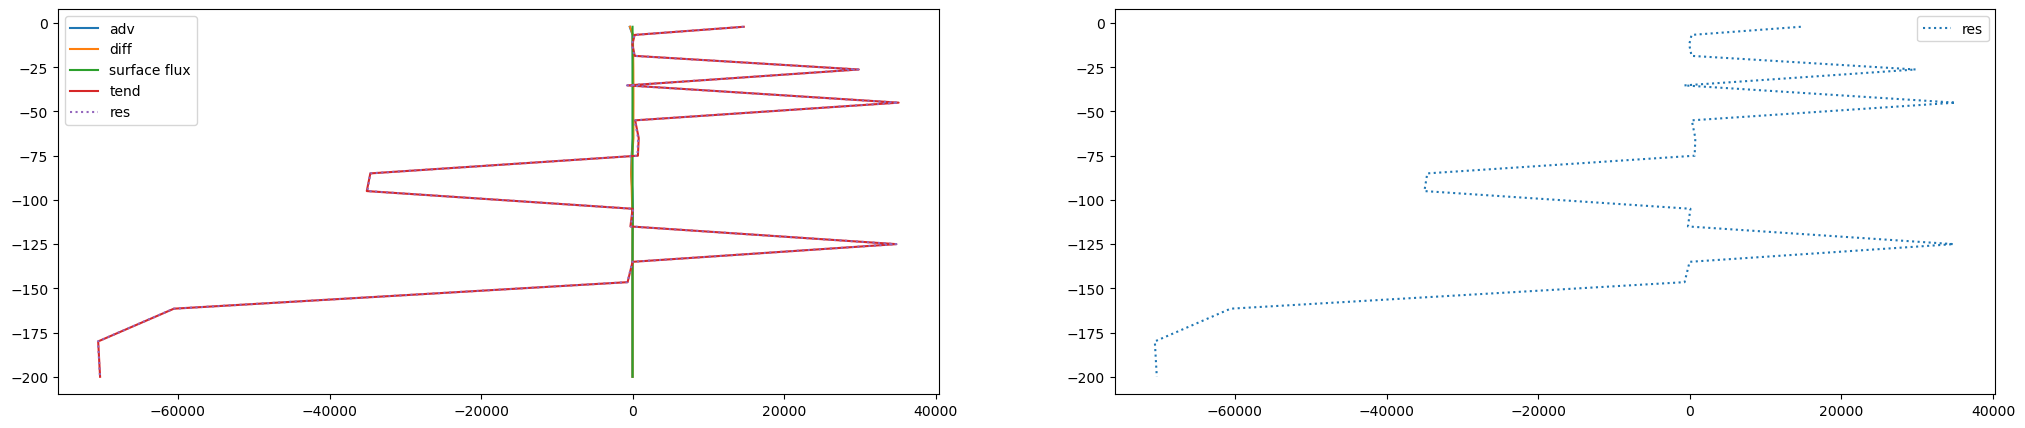

In [59]:
# Salt budget example vertical profile
# Here the salt divergence term is quite negligible

iy = 580
ix = 1200
fig, axs = plt.subplots(1,2,figsize=(25,5))
axs[0].plot(ADV_SALT.isel(time=0,XC=ix, YC=iy)[:20],ds.Z[:20],label = 'adv')
axs[0].plot(DF_SALT.isel(time=0,XC=ix, YC=iy)[:20],ds.Z[:20],label = 'diff')
axs[0].plot(SALTFLX.isel(time=0,XC=ix, YC=iy)[:20],ds.Z[:20],label = 'surface flux')
#axs[0].plot(DIV_SALT.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'DIV_SALT')
axs[0].plot(SALT_TEND.isel(time=0,XC=ix, YC=iy)[:20],ds.Z[:20],label = 'tend')
axs[0].plot(RES.isel(time=0,XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'res',linestyle = ':')
axs[1].plot(RES.isel(time=0,XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'res',linestyle = ':')
axs[0].legend()
axs[1].legend()
plt.show()

In [60]:
ds=ds.drop_vars(["ADVx_SLT","ADVx_SLT","ADVr_SLT",
                 "DFxE_SLT","DFyE_SLT","DFrI_SLT"])

In [61]:
del(ADV_SALT,ADV_SLT2D,
    DF_SALT,DIFF_SLT2D,
    SALT_TEND,SALT_TEND2D,
    LHS,RHS,RES,RES2D,
    SALTFLX ,SALTFLX2D)

In [62]:
ds["sigma2"] = gsw.density.sigma2(ds["SALT"], ds["THETA"])

In [63]:
ds["sigma2_bounds"] = gsw.density.sigma2(ds["SALT_bounds"], ds["THETA_bounds"])

In [64]:
ds=ds.drop_vars(["sTHETA","sSALIN"])

In [65]:
ds["mask2D"] = (1.-ds.maskInC)
ds["land"] = (ds.mask2D == 1)

In [68]:
ds=ds.roll(XC=500, roll_coords=True).roll(XG=500, roll_coords=True)

In [69]:
XC_TEMP=ds.XC.values
for i in range(len(XC_TEMP)):
    if XC_TEMP[i] > XC_TEMP[-1]:
        XC_TEMP[i] -= 360.

XG_TEMP=ds.XG.values
for i in range(len(XG_TEMP)):
    if XG_TEMP[i] > XG_TEMP[-1]:
        XG_TEMP[i] -= 360.

In [102]:
ds_out = ds.isel(XG=slice(125,480),XC=slice(125,479),YG=slice(0,290),YC=slice(0,289))

In [107]:
ds_out

<xarray.Dataset> Size: 1GB
Dimensions:           (YC: 289, XG: 355, Z: 52, time: 1, XC: 354, YG: 290,
                       Zl: 52, time_bounds: 2)
Coordinates: (12/38)
  * YC                (YC) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
  * XG                (XG) float32 1kB -62.5 -62.33 -62.17 ... -3.667 -3.5
  * Z                 (Z) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (YC, XG) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    dxC               (YC, XG) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    rAw               (YC, XG) float32 410kB 0.0 0.0 0.0 ... 7.245e+07 7.245e+07
    ...                ...
  * time_bounds       (time_bounds) datetime64[ns] 16B 2012-12-31 2013-01-30
    drW               (Z, YC, XG) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drS               (Z, YG, XC) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drC               (Z, YC, XC) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CV                (YC, XC, Z) float32 21MB 0.0 0.0 0.0 ... 2.898e+10 0.0 0.0
    rAW               (YC, XG, Z) float32 21MB 0.0 0.0 0.0 ... 3.405e+06 0.0 0.0
Data variables: (12/37)
    UVELMASS          (time, Z, YC, XG) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VVELMASS          (time, Z, YG, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    WVELMASS          (time, Zl, YC, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    oceFWflx          (time, YC, XC) float32 409kB 0.0 0.0 ... 2.93e-07
    THETA             (time, Z, YC, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ADVy_TH           (time, Z, YG, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                ...
    DELTA_DFyE_SLT    (time, Z, YC, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DELTA_DFrI_SLT    (time, Z, YC, XC) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sigma2            (time, Z, YC, XC) float64 43MB 9.785 9.785 ... 9.785 9.785
    sigma2_bounds     (time_bounds, Z, YC, XC) float64 85MB 9.785 ... 9.785
    mask2D            (YC, XC) float64 818kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    land              (YC, XC) bool 102kB True True True ... False False False

In [108]:
ds_out=ds_out.transpose("time","time_bounds","Z","Zl","YC","YG","XC","XG")

In [109]:
nXG = np.size(ds_out.XG)
nYG = np.size(ds_out.YG)
nXC = np.size(ds_out.XC)
nYC = np.size(ds_out.YC)
nZ = np.size(ds_out.Z)

XG_TEMP = np.zeros(nXG+1)
XG_TEMP[:-1] = ds_out.XG.values
XG_TEMP[-1] = ds_out.XG.values[0] + 360.
XG_TEMP

ds_out['XG_TEMP'] = xr.DataArray(data = XG_TEMP, 
                               dims = ['XG_TEMP'])

UMASSTRANS_TEMP = np.zeros([1,nZ,nYC,nXG+1])
UMASSTRANS_TEMP[:,:,:,:-1] = ds_out.UMASSTRANS.values
UMASSTRANS_TEMP[:,:,:,-1] = ds_out.UMASSTRANS.values[:,:,:,0]

ds_out['UMASSTRANS_TEMP'] = xr.DataArray(data = UMASSTRANS_TEMP, 
                               dims = ['time','Z','YC','XG_TEMP'],
                               coords = {'time': ds_out["time"],
                                         'Z': ds_out['Z'],
                                         'YC': ds_out['YC'],
                                         'XG_TEMP': ds_out['XG_TEMP']})

Diags=["dyG","dxC","rAw","maskInW","rSurfW","rLowW"]

for diag in Diags:
    TEMP = np.zeros([nYC,nXG+1])
    TEMP[:,:-1] = ds_out[diag].values
    TEMP[:,-1] = ds_out[diag].values[:,0] 
    ds_out[f'{diag}_TEMP'] = xr.DataArray(data = TEMP, 
                               dims = ['YC','XG_TEMP'],
                               coords = {'YC': ds_out['YC'],
                                         'XC': ds_out['XG_TEMP']})
    
Diags=["hFacW","maskW","drW","rAW"]

for diag in Diags:
    TEMP = np.zeros([nZ,nYC,nXG+1])
    TEMP[:,:,:-1] = ds_out[diag].values
    TEMP[:,:,-1] = ds_out[diag].values[:,:,0] 
    ds_out[f'{diag}_TEMP'] = xr.DataArray(data = TEMP, 
                               dims = ['Z','YC','XG_TEMP'],
                               coords = {'Z': ds_out['Z'],
                                         'YC': ds_out['YC'],
                                         'XC': ds_out['XG_TEMP']})


ds_out = ds_out.drop_vars(["UVELMASS","VVELMASS","WVELMASS",
                           "UMASSTRANS",
                           "dyG","dxC","rAw","maskInW","rSurfW","rLowW",
                           "hFacW","maskW","drW","rAW" ])
ds_out = ds_out.drop_vars(["XG"])

Diags=["XG","UMASSTRANS","dyG","dxC","rAw","maskInW","rSurfW","rLowW","hFacW","maskW","drW","rAW"]

for diag in Diags:
    ds_out = ds_out.rename({f"{diag}_TEMP":diag})

ds_out=ds_out.set_coords(["dyG","dxC","rAw","maskInW","rSurfW","rLowW","hFacW","maskW","drW","rAW"])

In [110]:
Zi = -6000.0*np.ones(53)
Zi[:52] = ds.Zl.values
Zi;

In [111]:
ds_out['Zi'] = xr.DataArray(data = Zi, 
                               dims = ['Zi'])

In [112]:
ds_out=ds_out.drop_vars(["UVELMASS","VVELMASS","WVELMASS"])

In [113]:
ds_out = ds_out.drop_vars(["Zl"])

In [114]:
geolon = np.zeros([nYC,nXC])
geolon[:,:] = np.reshape(ds_out.XC.values, [1,nXC])
geolon_c = np.zeros([nYG,nXG])
geolon_c[:,:] = np.reshape(ds_out.XG.values, [1,nXG])
geolon_u = np.zeros([nYC,nXG])
geolon_u[:,:] = np.reshape(ds_out.XG.values, [1,nXG])
geolon_v = np.zeros([nYG,nXC])
geolon_v[:,:] = np.reshape(ds_out.XC.values, [1,nXC])

geolat = np.zeros([nYC,nXC])
geolat[:,:] = np.reshape(ds_out.YC.values, [nYC,1])
geolat_c = np.zeros([nYG,nXG])
geolat_c[:,:] = np.reshape(ds_out.YG.values, [nYG,1])
geolat_u = np.zeros([nYC,nXG])
geolat_u[:,:] = np.reshape(ds_out.YC.values, [nYC,1])
geolat_v = np.zeros([nYG,nXC])
geolat_v[:,:] = np.reshape(ds_out.YG.values, [nYG,1])

In [115]:
ds_out['geolon'] = xr.DataArray(data = geolon, 
                               dims = ['YC','XC'],
                               coords = {'YC': ds_out['YC'],
                                         'XC': ds_out['XC']})
ds_out['geolat'] = xr.DataArray(data = geolat, 
                               dims = ['YC','XC'],
                               coords = {'YC': ds_out['YC'],
                                         'XC': ds_out['XC']})


ds_out['geolon_c'] = xr.DataArray(data = geolon_c, 
                               dims = ['YG','XG'],
                               coords = {'YG': ds_out['YG'],
                                         'XG': ds_out['XG']})
ds_out['geolat_c'] = xr.DataArray(data = geolat_c, 
                               dims = ['YG','XG'],
                               coords = {'YG': ds_out['YG'],
                                         'XG': ds_out['XG']})


ds_out['geolon_u'] = xr.DataArray(data = geolon_u, 
                               dims = ['YC','XG'],
                               coords = {'YC': ds_out['YC'],
                                         'XG': ds_out['XG']})
ds_out['geolat_u'] = xr.DataArray(data = geolat_u, 
                               dims = ['YC','XG'],
                               coords = {'YC': ds_out['YC'],
                                         'XG': ds_out['XG']})


ds_out['geolon_v'] = xr.DataArray(data = geolon_v, 
                               dims = ['YG','XC'],
                               coords = {'YG': ds_out['YG'],
                                         'XC': ds_out['XC']})
ds_out['geolat_v'] = xr.DataArray(data = geolat_v, 
                               dims = ['YG','XC'],
                               coords = {'YG': ds_out['YG'],
                                         'XC': ds_out['XC']})
ds_out = ds_out.set_coords(["geolon","geolon_c",
                            "geolon_u","geolon_v",
                            "geolat","geolat_c",
                            "geolat_u","geolat_v"])
ds_out["lat"] = ds_out["geolat"]
ds_out["lon"] = ds_out["geolon"]
ds_out = ds_out.set_coords(["lat","lon"])

In [116]:
ds_out = ds_out.rename({"XC":"xh","YC":"yh","XG":"xq","YG":"yq"})

In [117]:
drC_bounds = np.zeros([2,nZ,nYC,nXC])
drC_bounds[:,:,:,:] = np.reshape(ds_out.drC.values, [1,nZ,nYC,nXC])
ds_out['drC_bounds'] = xr.DataArray(data = drC_bounds, 
                               dims = ['time_bounds','Z','yh','xh'],
                               coords = {'time_bounds': ds_out['time_bounds'],
                                         'Z': ds_out['Z'],
                                         'yh': ds_out['yh'],
                                         'xh': ds_out['xh']})

In [118]:
ds_out = ds_out.rename({"Z":"z_l","Zi":"z_i"})

In [119]:
ds_out["drC"]=ds_out.drC.expand_dims("time")

In [120]:
ds_out["SST"] = ds_out["THETA"].isel(z_l=0)
ds_out["SSS"] = ds_out["SALT"].isel(z_l=0)

In [121]:
ds_out

<xarray.Dataset> Size: 1GB
Dimensions:           (yh: 289, xq: 355, z_l: 52, xh: 354, yq: 290, time: 1,
                       time_bounds: 2, z_i: 53)
Coordinates: (12/48)
  * yh                (yh) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
  * xq                (xq) float32 1kB -62.5 -62.33 -62.17 ... -3.667 -3.5
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    dxC               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    rAw               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 7.245e+07 7.245e+07
    ...                ...
    geolon_u          (yh, xq) float64 821kB -62.5 -62.33 -62.17 ... -3.667 -3.5
    geolat_u          (yh, xq) float64 821kB -77.98 -77.98 ... -62.65 -62.65
    geolon_v          (yq, xh) float64 821kB -62.42 -62.25 ... -3.75 -3.583
    geolat_v          (yq, xh) float64 821kB -78.0 -78.0 -78.0 ... -62.62 -62.62
    lat               (yh, xh) float64 818kB -77.98 -77.98 ... -62.65 -62.65
    lon               (yh, xh) float64 818kB -62.42 -62.25 ... -3.75 -3.583
Data variables: (12/37)
    oceFWflx          (time, yh, xh) float32 409kB 0.0 0.0 ... 2.93e-07
    THETA             (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_TH           (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SALT              (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_SLT          (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SFLUX             (time, yh, xh) float32 409kB 0.0 0.0 ... 9.192e-06
    ...                ...
    sigma2_bounds     (time_bounds, z_l, yh, xh) float64 85MB 9.785 ... 9.785
    mask2D            (yh, xh) float64 818kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    land              (yh, xh) bool 102kB True True True ... False False False
    drC_bounds        (time_bounds, z_l, yh, xh) float64 85MB 0.0 0.0 ... 0.0
    SST               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 2.087 2.094
    SSS               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 33.81 33.81

In [122]:
ds_out["maskZ"] = xr.DataArray(np.zeros(len(ds_out['z_l'])),dims=['z_l'],coords={'z_l':ds_out['z_l']})
ds_out["maskZ"][0] = 1 
ds_out = ds_out.set_coords("maskZ")

In [123]:
ds_out["oceFWflx"]=ds_out["oceFWflx"]*ds_out.maskZ

In [124]:
ds_out["TFLUXmSW"] = ds_out["TFLUXmSW"]*ds_out.maskZ
ds_out["SFLUX"] = ds_out["SFLUX"]*ds_out.maskZ

In [125]:
ds_out["DELTA_ADVh_TH"] = ds_out["DELTA_ADVx_TH"] + ds_out["DELTA_ADVy_TH"]
ds_out["DELTA_ADVh_TH"].compute();

In [126]:
ds_out["DELTA_DFhE_TH"] = ds_out["DELTA_DFxE_TH"] + ds_out["DELTA_DFyE_TH"]
ds_out["DELTA_DFhE_TH"].compute();

In [127]:
ds_out["DELTA_ADVh_SLT"] = ds_out["DELTA_ADVx_SLT"] + ds_out["DELTA_ADVy_SLT"]
ds_out["DELTA_ADVh_SLT"].compute();

In [128]:
ds_out["DELTA_DFhE_SLT"] = ds_out["DELTA_DFxE_SLT"] + ds_out["DELTA_DFyE_SLT"]
ds_out["DELTA_DFhE_SLT"].compute();

In [129]:
ds_out=ds_out.drop_vars(["DELTA_ADVx_TH","DELTA_ADVy_TH",
                         "DELTA_DFxE_TH","DELTA_DFyE_TH",
                         "DELTA_ADVx_SLT","DELTA_ADVy_SLT",
                         "DELTA_DFxE_SLT","DELTA_DFyE_SLT"])

In [130]:
ds_out = ds_out.set_coords(["depthC","mask2D","land"])

In [131]:
ds_out=ds_out.transpose("time","time_bounds","z_l","z_i","yh","yq","xh","xq")
ds_out

<xarray.Dataset> Size: 1GB
Dimensions:           (yh: 289, xq: 355, z_l: 52, xh: 354, yq: 290, time: 1,
                       time_bounds: 2, z_i: 53)
Coordinates: (12/52)
  * yh                (yh) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
  * xq                (xq) float32 1kB -62.5 -62.33 -62.17 ... -3.667 -3.5
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    dxC               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    rAw               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 7.245e+07 7.245e+07
    ...                ...
    geolat_u          (yh, xq) float64 821kB -77.98 -77.98 ... -62.65 -62.65
    geolon_v          (yq, xh) float64 821kB -62.42 -62.25 ... -3.75 -3.583
    geolat_v          (yq, xh) float64 821kB -78.0 -78.0 -78.0 ... -62.62 -62.62
    lat               (yh, xh) float64 818kB -77.98 -77.98 ... -62.65 -62.65
    lon               (yh, xh) float64 818kB -62.42 -62.25 ... -3.75 -3.583
    maskZ             (z_l) float64 416B 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables: (12/30)
    oceFWflx          (time, z_l, yh, xh) float64 43MB 0.0 0.0 0.0 ... 0.0 0.0
    THETA             (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_TH           (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SALT              (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_SLT          (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SFLUX             (time, z_l, yh, xh) float64 43MB 0.0 0.0 0.0 ... 0.0 0.0
    ...                ...
    SST               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 2.087 2.094
    SSS               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 33.81 33.81
    DELTA_ADVh_TH     (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFhE_TH     (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_ADVh_SLT    (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFhE_SLT    (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0

In [132]:
ds_out

<xarray.Dataset> Size: 1GB
Dimensions:           (yh: 289, xq: 355, z_l: 52, xh: 354, yq: 290, time: 1,
                       time_bounds: 2, z_i: 53)
Coordinates: (12/52)
  * yh                (yh) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
  * xq                (xq) float32 1kB -62.5 -62.33 -62.17 ... -3.667 -3.5
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    dxC               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 8.512e+03 8.512e+03
    rAw               (yh, xq) float32 410kB 0.0 0.0 0.0 ... 7.245e+07 7.245e+07
    ...                ...
    geolat_u          (yh, xq) float64 821kB -77.98 -77.98 ... -62.65 -62.65
    geolon_v          (yq, xh) float64 821kB -62.42 -62.25 ... -3.75 -3.583
    geolat_v          (yq, xh) float64 821kB -78.0 -78.0 -78.0 ... -62.62 -62.62
    lat               (yh, xh) float64 818kB -77.98 -77.98 ... -62.65 -62.65
    lon               (yh, xh) float64 818kB -62.42 -62.25 ... -3.75 -3.583
    maskZ             (z_l) float64 416B 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables: (12/30)
    oceFWflx          (time, z_l, yh, xh) float64 43MB 0.0 0.0 0.0 ... 0.0 0.0
    THETA             (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_TH           (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SALT              (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    ADVy_SLT          (time, z_l, yq, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    SFLUX             (time, z_l, yh, xh) float64 43MB 0.0 0.0 0.0 ... 0.0 0.0
    ...                ...
    SST               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 2.087 2.094
    SSS               (time, yh, xh) float32 409kB 0.0 0.0 0.0 ... 33.81 33.81
    DELTA_ADVh_TH     (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFhE_TH     (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_ADVh_SLT    (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0
    DELTA_DFhE_SLT    (time, z_l, yh, xh) float32 21MB 0.0 0.0 0.0 ... 0.0 0.0

In [133]:
ds_out.to_netcdf("./SOSE_xWMB_data_Weddell_january_2013.nc")